# __Heart Disease Prediction using Machine Learning__

<div class="alert alert-block alert-info">
<b>Project Tasks:</b> This notebook implements various classification algorithms to predict heart disease based on the provided dataset. The steps include:

- Data preprocessing
- Model training and evaluation
- Model Improvements
- Model Comparison and Interpretation
</div>

In [160]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

# Models to be implemented
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [161]:
# Load the dataset as "heart_data"
file_path = 'heart.csv'  # Update path if necessary
heart_data = pd.read_csv(file_path)

# Display basic information about the dataset
heart_data.info()
heart_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## __Data Preprocessing__

#### We have a mix of categorical and numerical features. Also, we see lots of 0's for cholesterol, these values are likely invalid or placeholders as cholesterol levels of 0 shouldnt be physiologically plausible. 

#### We must:
#### - Handle Missing Value Handling
#### - Encode categorical features
#### - Divide the dataset into training (80%) and testing (20%)

In [ ]:
# Handle missing or invalid values
heart_data['RestingBP'].replace(0, heart_data['RestingBP'].median(), inplace=True)
heart_data['Cholesterol'].replace(0, heart_data['Cholesterol'].median(), inplace=True)

# Define feature and target columns
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target = 'HeartDisease'

# Split data into train and test sets
X = heart_data.drop(columns=[target])
y = heart_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

# Define pipelines and hyperparameter for ensemble models ( WILL USE FURTHER IN NOTEBOOK)


### Logistic Regression pipeline ###
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

### Bagging Classifier Pipeline ###
bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(random_state=42))
])

### AdaBoost Classifier Pipeline ###
adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])


### Bagging Hyperparameter Grid ###
bagging_param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_samples': [0.5, 0.75, 1.0],
    'classifier__max_features': [0.5, 0.75, 1.0],
    'classifier__bootstrap': [True, False]
}

### AdaBoost Hyperparameter Grid ###
adaboost_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__estimator': [
        DecisionTreeClassifier(max_depth=1, random_state=42),
        DecisionTreeClassifier(max_depth=2, random_state=42)
    ]
}

### Logistic Regression parameter grid ###
param_grid = {
    'classifier__penalty': ['l1', 'l2'],  # Regularization: L1 (Lasso) or L2 (Ridge)
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (inverse of lambda)
    'classifier__solver': ['liblinear', 'saga']  # Solvers that support L1/L2 regularization
}

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing step
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid for Random Forest

# FOR TUNING 
# rf_param_grid = {
    # 'classifier__n_estimators': [100, 200, 300],  # Number of trees
    # 'classifier__max_depth': [None, 10, 20, 30],  # Depth of trees
    # 'classifier__min_samples_split': [2, 5, 10],  # Min samples to split an internal node
    # 'classifier__min_samples_leaf': [1, 2, 4],    # Min samples at leaf node
    # 'classifier__bootstrap': [True, False]        # Whether to use bootstrap samples
# }

# FOR WEIGHTED CLASS
rf_param_grid = {
    'classifier__n_estimators': [300, 400, 500],       # Number of trees
    'classifier__max_depth': [20, 30, 40],             # Tree depth
    'classifier__min_samples_split': [2, 5],           # Minimum samples required to split
    'classifier__min_samples_leaf': [1, 2],            # Minimum samples at a leaf
    'classifier__max_features': ['sqrt', 'log2'],      # Features considered for the best split
    'classifier__class_weight': ['balanced']           # Automatically balance class weights
}


# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing step
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 200],          # Number of boosting rounds
    'classifier__max_depth': [3, 5, 7],                 # Maximum depth of trees
    'classifier__learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'classifier__subsample': [0.6, 0.8, 1.0],           # Subsample ratio
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]     # Subsample ratio of columns
}

C:\Users\benit\AppData\Local\Temp\ipykernel_6664\1825400184.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_data['RestingBP'].replace(0, heart_data['RestingBP'].median(), inplace=True)
C:\Users\benit\AppData\Local\Temp\ipykernel_6664\1825400184.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

## __Model Training and Evaluation__

#### Our data invloves a binary classification problem as we are predicting HeartDisease(1 or 0)
#### We want a model that can capture non-linear relationships and provide interpretability !
#### As seen from HW 3, ensemble models prove themselves with our type of dataset
#### BUT it never hurts to test and observe some baseline models we learned about in this course


First we will test our __Baseline / Non-Ensemble__ Models that learn and make predictions independently

Training Logistic Regression...

Logistic Regression Evaluation Metrics:
Confusion Matrix:
[[71 11]
 [11 91]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



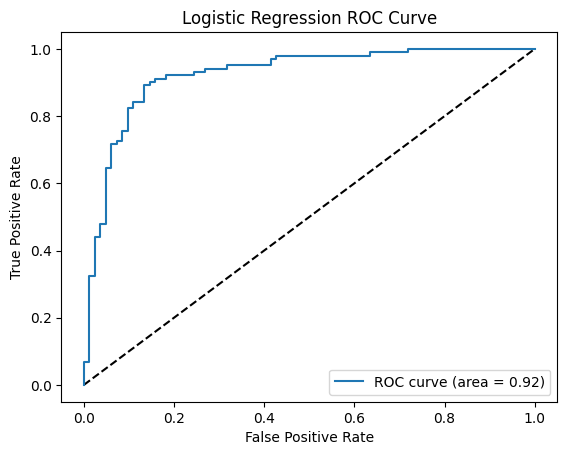

Training MLP (Neural Network)...

MLP (Neural Network) Evaluation Metrics:
Confusion Matrix:
[[66 16]
 [20 82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        82
           1       0.84      0.80      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184



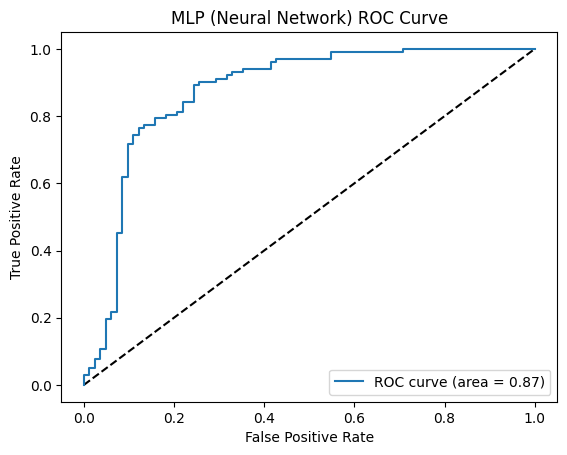

Training Naïve Bayes...

Naïve Bayes Evaluation Metrics:
Confusion Matrix:
[[71 11]
 [19 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        82
           1       0.88      0.81      0.85       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



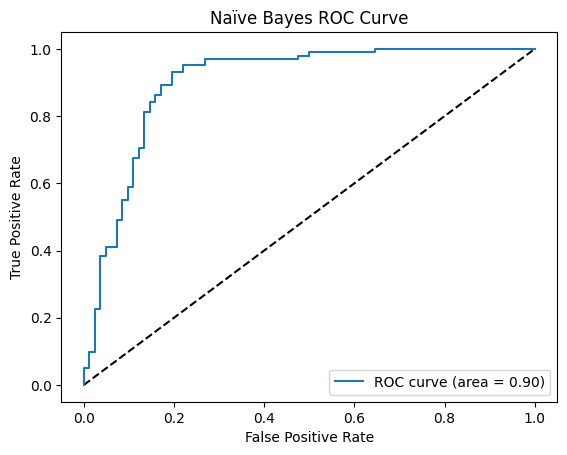

Training SVM (Linear Kernel)...

SVM (Linear Kernel) Evaluation Metrics:
Confusion Matrix:
[[60 22]
 [22 80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        82
           1       0.78      0.78      0.78       102

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.76      0.76      0.76       184



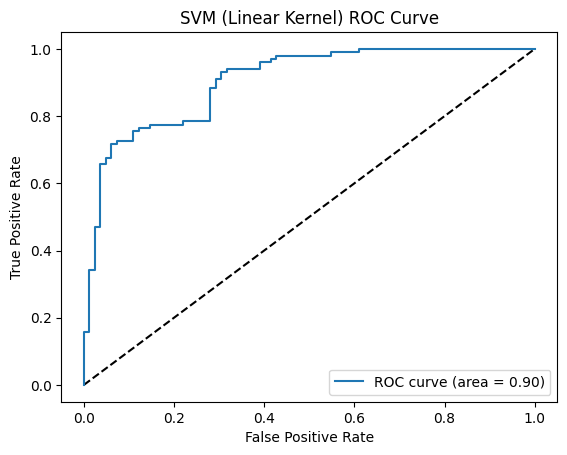

Training Decision Tree...

Decision Tree Evaluation Metrics:
Confusion Matrix:
[[62 20]
 [26 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        82
           1       0.79      0.75      0.77       102

    accuracy                           0.75       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.75      0.75      0.75       184



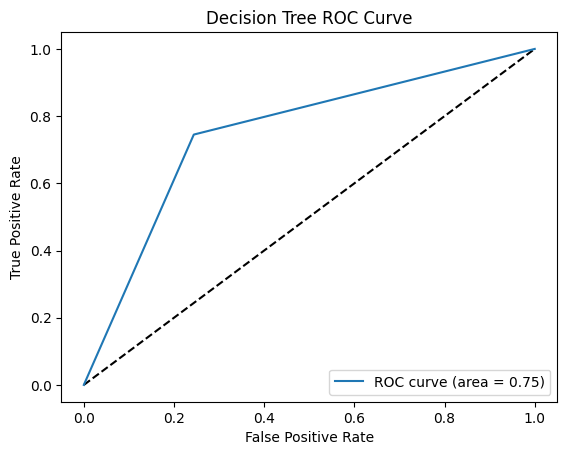

In [165]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Define baseline classifiers
baseline_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42),
    "Naïve Bayes": GaussianNB(),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Train and evaluate baseline classifiers
for method, clf in baseline_classifiers.items():
    print(f"Training {method}...\n")
    
    # Create a pipeline with preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None  # For ROC curve
    
    # Evaluate the model
    print(f"{method} Evaluation Metrics:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Compute ROC curve (if probability scores are available)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        the_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=f"ROC curve (area = {the_auc:.2f})")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{method} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"{method} does not support probability scores for ROC analysis.\n")


Now we can evaluate our __Ensemble Models__ similar to HW 3

Training Bagging...

Bagging Evaluation Metrics:
Confusion Matrix:
[[71 11]
 [13 89]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        82
           1       0.89      0.87      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



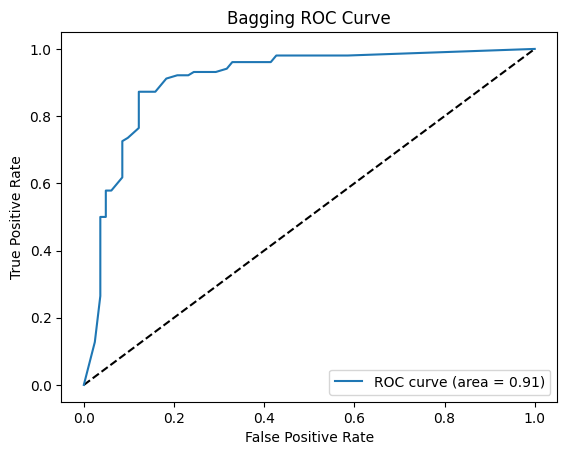

Training AdaBoost...

AdaBoost Evaluation Metrics:
Confusion Matrix:
[[70 12]
 [15 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        82
           1       0.88      0.85      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


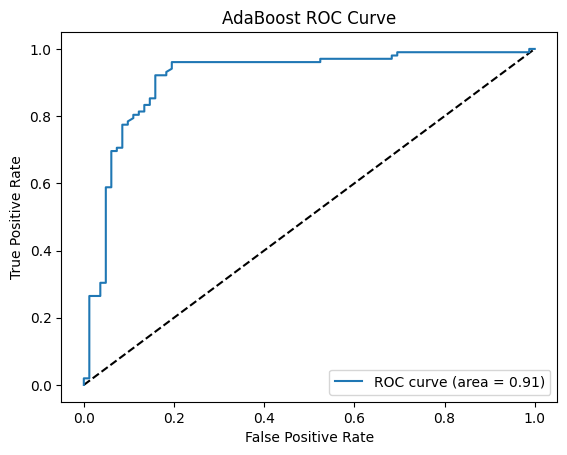

Training Random Forest...

Random Forest Evaluation Metrics:
Confusion Matrix:
[[71 11]
 [12 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        82
           1       0.89      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



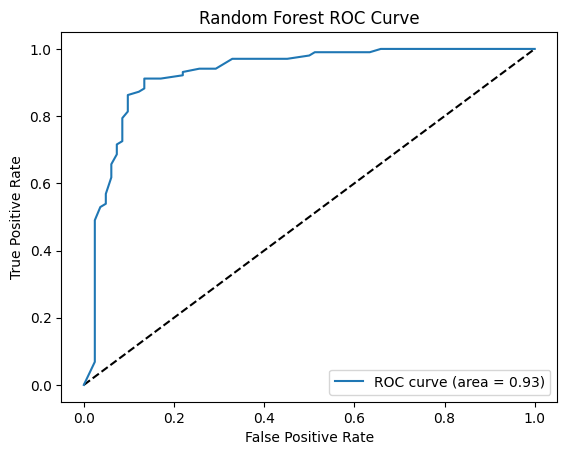

Training XGBoost...

XGBoost Evaluation Metrics:
Confusion Matrix:
[[69 13]
 [16 86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        82
           1       0.87      0.84      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


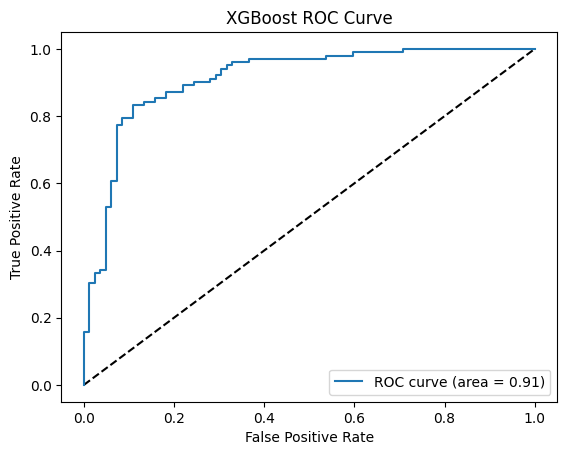

In [166]:
# Define ensemble classifiers
classifiers = {
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate classifiers
for method, clf in classifiers.items():
    print(f"Training {method}...\n")
    
    # Create a pipeline with preprocessing and classifier (ENSURES OUR DATA IS PREPROCESSED)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # For ROC curve
    
    # Evaluate the model
    print(f"{method} Evaluation Metrics:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    the_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f"ROC curve (area = {the_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{method} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

##  __Model Improvements__

#### Logistic Regression & Random Forest produced highest precsion: 88%
#### Medical datasets often benefit from ensemble method, and seeing as they were not far off 88% we'll attempt to improve these models aswell

First we will tune __Logistic Regression__
- We will try Hyperparameters as it is typically recommended for all models
- Also, we will apply Regularization Techniques to prevent any overfitting

Tuning Logistic Regression...
Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8487279843444228

Confusion Matrix:
[[72 10]
 [12 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        82
           1       0.90      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



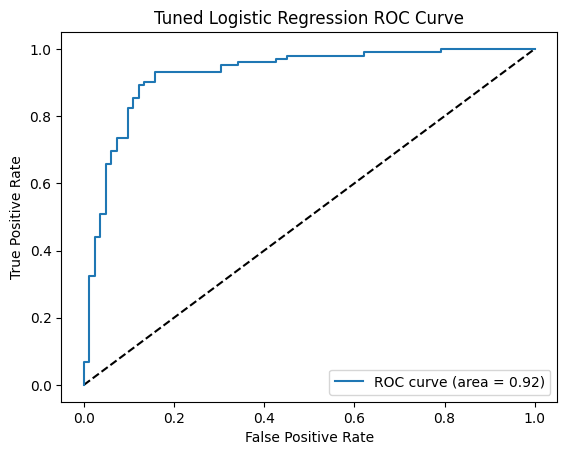

In [167]:
from sklearn.model_selection import GridSearchCV

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    log_reg_pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1)

print("Tuning Logistic Regression...")
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Evaluate the tuned model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve for the tuned Logistic Regression model
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()


Both the untuned and tuned Logistic Regression models perform similarly in terms of accuracy, achieving 88% accuracy on the test set

Let us try __Feature Selection__ to this same model !
- We will iteratively removes less important features based on model coefficients until the optimal subset is found(Recursive Feature Elimination)

Selected Features: Index(['cat__Sex_F', 'cat__Sex_M', 'cat__ChestPainType_ASY',
       'cat__ChestPainType_ATA', 'cat__ChestPainType_NAP',
       'cat__ExerciseAngina_N', 'cat__ExerciseAngina_Y', 'cat__ST_Slope_Flat',
       'cat__ST_Slope_Up'],
      dtype='object')
Confusion Matrix:
[[69 13]
 [15 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        82
           1       0.87      0.85      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



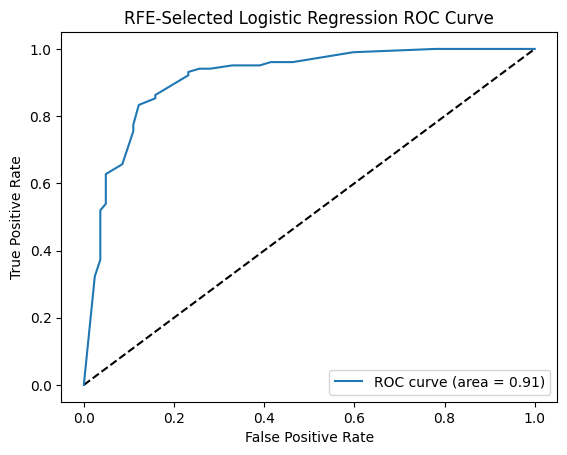

In [168]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Initialize the Logistic Regression model
base_lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42)

# FIRST WE MUST use preprocessor.get_feature_names_out() to match the feature mask as 
# the preprocessor changes our feature names due to the one-hot encoding we did !
# By adjusting the dataset, we ensure X_train_selected and X_test_selected align with the selected features.

# Preprocess the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# RFE expects a DataFrame or array
rfe = RFE(estimator=base_lr, n_features_to_select=9)  # Change number of features to find best accuracy
rfe.fit(X_train_transformed, y_train)

# Get selected feature mask from the preprocessor
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out(input_features=X.columns)
else:
    feature_names = X.columns

selected_features = rfe.support_
selected_feature_names = pd.Index(feature_names)[selected_features]
print("Selected Features:", selected_feature_names)

# Update the datasets with selected features
X_train_selected = X_train_transformed[:, selected_features]
X_test_selected = X_test_transformed[:, selected_features]

# Retrain Logistic Regression with selected features
rfe_lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42)
rfe_lr.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = rfe_lr.predict(X_test_selected)
y_prob = rfe_lr.predict_proba(X_test_selected)[:, 1]

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
the_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"ROC curve (area = {the_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RFE-Selected Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()


After alternating the number features to select, we found decreasing the features lead to a decrease in accuaracy
 
Feature selection did not improve performance, which suggests all or most of our features may already be relevant

Lets move on to our Ensemble Methods which are non-linear models that often perform better for more complex datasets.


__We will start with Hyperparameter Tuning our Bagging & AdaBoost models__

Tuning Bagging Classifier...
Best Parameters for Bagging: {'classifier__bootstrap': True, 'classifier__max_features': 0.5, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy for Bagging: 0.8678128785760879
Confusion Matrix:
[[69 13]
 [ 9 93]]

Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



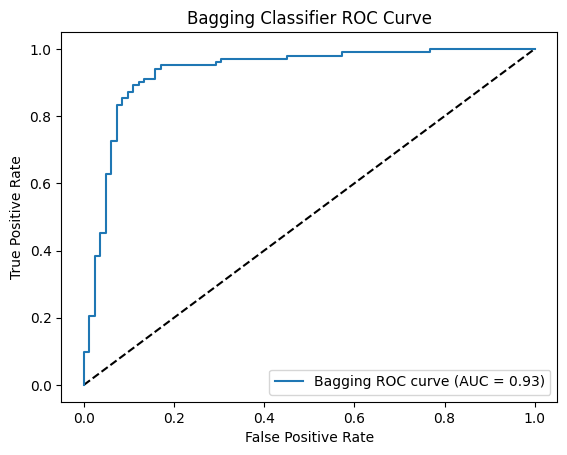

In [169]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Bagging Classifier Hyperparameter Tuning
print("Tuning Bagging Classifier...")

bagging_grid_search = GridSearchCV(
    estimator=bagging_pipeline,
    param_grid=bagging_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

bagging_grid_search.fit(X_train, y_train)

print("Best Parameters for Bagging:", bagging_grid_search.best_params_)
print("Best Cross-Validation Accuracy for Bagging:", bagging_grid_search.best_score_)

# Evaluate the tuned Bagging Classifier on the test set
best_bagging_model = bagging_grid_search.best_estimator_
bagging_y_pred = best_bagging_model.predict(X_test)
bagging_y_prob = best_bagging_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, bagging_y_pred))
print("\nBagging Classification Report:")
print(classification_report(y_test, bagging_y_pred))

# Plot ROC Curve for Bagging
fpr, tpr, _ = roc_curve(y_test, bagging_y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"Bagging ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()



Tuning AdaBoost Classifier...
Best Parameters for AdaBoost: {'classifier__estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
Best Cross-Validation Accuracy for AdaBoost: 0.8487186655484111
Confusion Matrix:
[[69 13]
 [18 84]]

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        82
           1       0.87      0.82      0.84       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


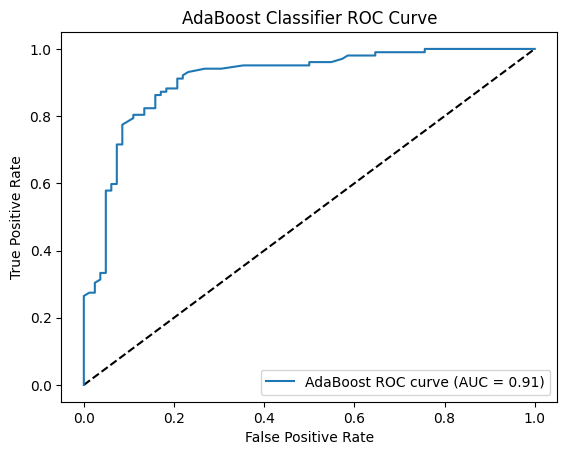

In [170]:
# AdaBoost Classifier Hyperparameter Tuning
print("\nTuning AdaBoost Classifier...")

adaboost_grid_search = GridSearchCV(
    estimator=adaboost_pipeline,
    param_grid=adaboost_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

adaboost_grid_search.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", adaboost_grid_search.best_params_)

print("Best Cross-Validation Accuracy for AdaBoost:", adaboost_grid_search.best_score_)

# Evaluate the tuned AdaBoost Classifier on the test set
best_adaboost_model = adaboost_grid_search.best_estimator_
adaboost_y_pred = best_adaboost_model.predict(X_test)
adaboost_y_prob = best_adaboost_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, adaboost_y_pred))
print("\nAdaBoost Classification Report:")
print(classification_report(y_test, adaboost_y_pred))

# Plot ROC Curve for AdaBoost
fpr, tpr, _ = roc_curve(y_test, adaboost_y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"AdaBoost ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

Unfortunately we could no surpass the 88 % threshold after refining the number of estimators, learning rate (AdaBoost), and sampling rates !

We will now focus on XGBoost and Random Forest by fine-tuning parameters like max_depth, n_estimators, and maybe learning_rate.


Tuning Random Forest...
Best Parameters for Random Forest: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Random Forest Evaluation Metrics:
Confusion Matrix:
[[70 12]
 [ 9 93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



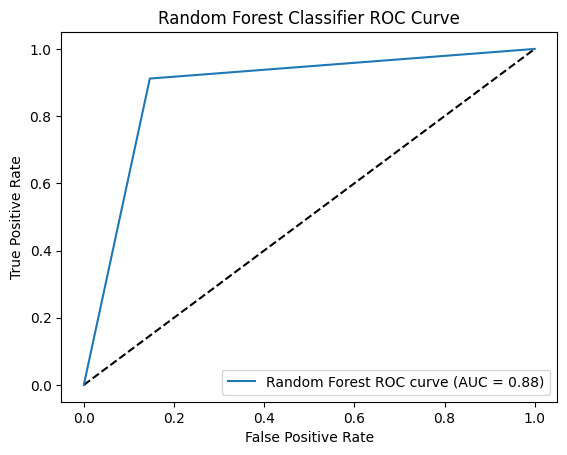

In [181]:
from sklearn.metrics import classification_report, confusion_matrix
# GridSearchCV for Random Forest
print("Tuning Random Forest...")
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
    
)

# Fit the Random Forest pipeline
rf_grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

# Evaluate Random Forest
rf_best_model = rf_grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)
print("Random Forest Evaluation Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_y_pred))
print("Classification Report:")
print(classification_report(y_test, rf_y_pred))

# Plot ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"Random Forest ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

Tuning XGBoost...


c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Best Parameters for XGBoost: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6}
XGBoost Evaluation Metrics:
Confusion Matrix:
[[68 14]
 [10 92]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        82
           1       0.87      0.90      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


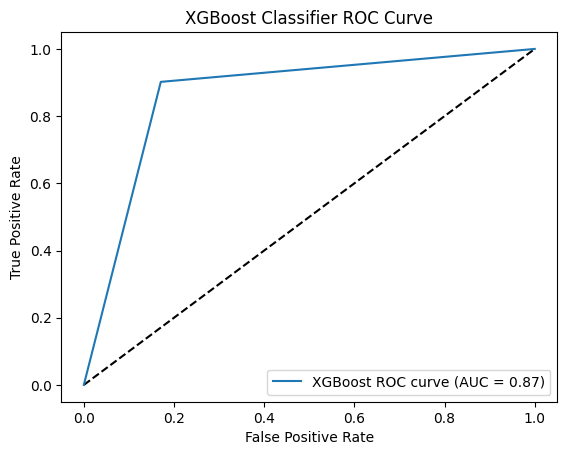

In [171]:
# GridSearchCV for XGBoost
print("Tuning XGBoost...")
xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

# Fit the XGBoost pipeline
xgb_grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate XGBoost
xgb_best_model = xgb_grid_search.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test)
print("XGBoost Evaluation Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_y_pred))
print("Classification Report:")
print(classification_report(y_test, xgb_y_pred))
# Plot ROC Curve for XGBoost
fpr, tpr, _ = roc_curve(y_test, xgb_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"XGBoost ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

We finally got passed the 88% Threshold ! __Random Forest: 89%__

XGBoost also saw a decent increase to __87%__

1% closer to "Perfectly" predicting heart failure. 
We know striving for perfect is not the goal here, but let's see if there are any more techniques to try and increase our accuracy a tiny bit more

__Weighted Voting Implementation__


Training Weighted Voting Classifier...
Weighted Voting Classifier Evaluation Metrics:
Confusion Matrix:
[[70 12]
 [ 9 93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



c:\Users\benit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


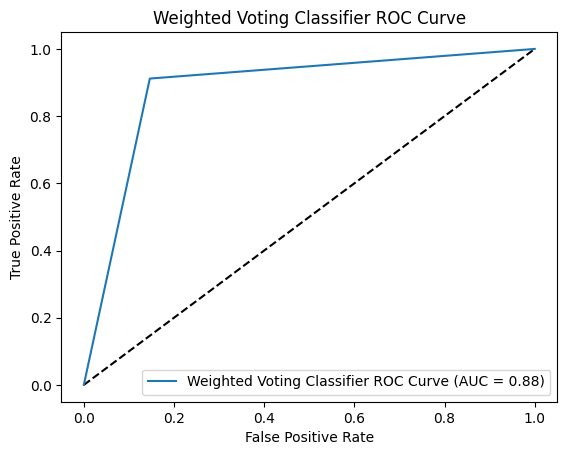

In [172]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Use the best estimators from Grid Search
rf_best_model = rf_grid_search.best_estimator_  # Best Random Forest model
xgb_best_model = xgb_grid_search.best_estimator_  # Best XGBoost model

# Define the weighted voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best_model),
        ('xgb', xgb_best_model)
    ],
    voting='soft',  # Use predicted probabilities for better calibration
    weights=[10, 1]  # Assign higher weight to Random Forest
)

# Fit the weighted voting classifier
print("Training Weighted Voting Classifier...")
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the model
print("Weighted Voting Classifier Evaluation Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))

# Plot ROC Curve for weighted model
fpr, tpr, _ = roc_curve(y_test, y_pred_voting)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"Weighted Voting Classifier ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Voting Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()


__Fine-Tuning and Class Weights (Random Forest)__

Tuning Random Forest...
Tuning Random Forest with Class Weights...
Best Parameters for Random Forest: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Random Forest Evaluation Metrics:
Confusion Matrix:
[[71 11]
 [11 91]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



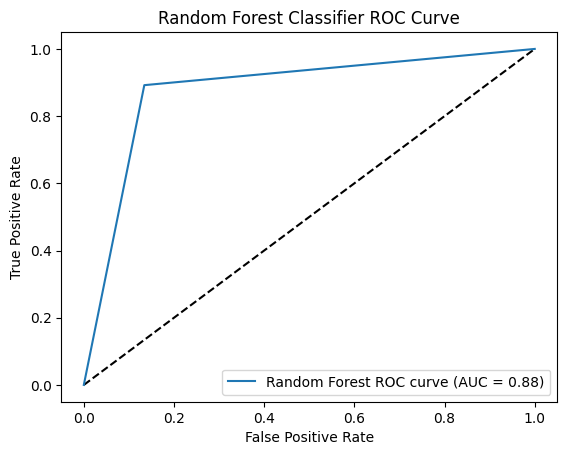

In [193]:
from sklearn.metrics import classification_report, confusion_matrix
# GridSearchCV for Random Forest
print("Tuning Random Forest...")
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0,
    n_jobs=-1
    
)

# Fit the grid search to the training data
print("Tuning Random Forest with Class Weights...")

# Fit the Random Forest pipeline
rf_grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

# Evaluate Random Forest
rf_best_model = rf_grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)
print("Random Forest Evaluation Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_y_pred))
print("Classification Report:")
print(classification_report(y_test, rf_y_pred))

# Plot ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"Random Forest ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

##  __Model Comparison and Interpretation__

#### We opted for evaluation metrics such as accuracy, precision, recall, and F1-score as we are dealing with a binary classification

#### Throughout our notebook you can see these metrics along with model performance metrics, such as ROC curves, and confusion matrices

In [194]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define a function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_test, y_pred))
    return metrics

# Evaluate all models
models = [
    ('Random Forest', rf_best_model),
    ('Bagging', best_bagging_model),
    ('Weighted Voting', voting_clf),
]

metrics = [evaluate_model(model, X_test, y_test, name) for name, model in models]

# Create a DataFrame to summarize the metrics
import pandas as pd
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)
print(metrics_df)
print()
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("GRAPHS CAN BE FOUND LABELED IN THE PAST CELLS ABOVE")

Confusion Matrix for Random Forest:
 [[71 11]
 [11 91]]
Confusion Matrix for Bagging:
 [[69 13]
 [ 9 93]]
Confusion Matrix for Weighted Voting:
 [[70 12]
 [ 9 93]]
                 Accuracy  Precision    Recall  F1-Score   ROC-AUC
Model                                                             
Random Forest    0.880435   0.892157  0.892157  0.892157  0.925873
Bagging          0.880435   0.877358  0.911765  0.894231  0.931373
Weighted Voting  0.885870   0.885714  0.911765  0.898551  0.926351

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
GRAPHS CAN BE FOUND LABELED IN THE PAST CELLS ABOVE


__*Analyze the strengths and weaknesses of each model in terms of predictive capability and computational efficiency.*__

Bagging: 
- Strong recall, good at capturing positive cases.
- Computationally more expensive than simpler models like Logistic Regression.
- Does not inherently focus on feature importance, making it less interpretable.


Logistic Regression (Honorable Mention): 
- Simple, interpretable, balanced across metrics.
- Limited capacity to capture complex relationships in data (linear decision boundary).

Random Forest: 
- High recall, robust and interpretable.
- Computationally efficient for training and prediction with smaller datasets.
- May slightly overfit if hyperparameters like max_depth or n_estimators are not tuned carefully.

Weighted Voting: 
- Combines strengths of Random Forest and XGBoost.
- Dependent on the performance of individual models.
- More complex to interpret compared to a single model.


__*Interpret the final results.*__



Since Random Forest produced the best results, we will graph the importance of the features for this model

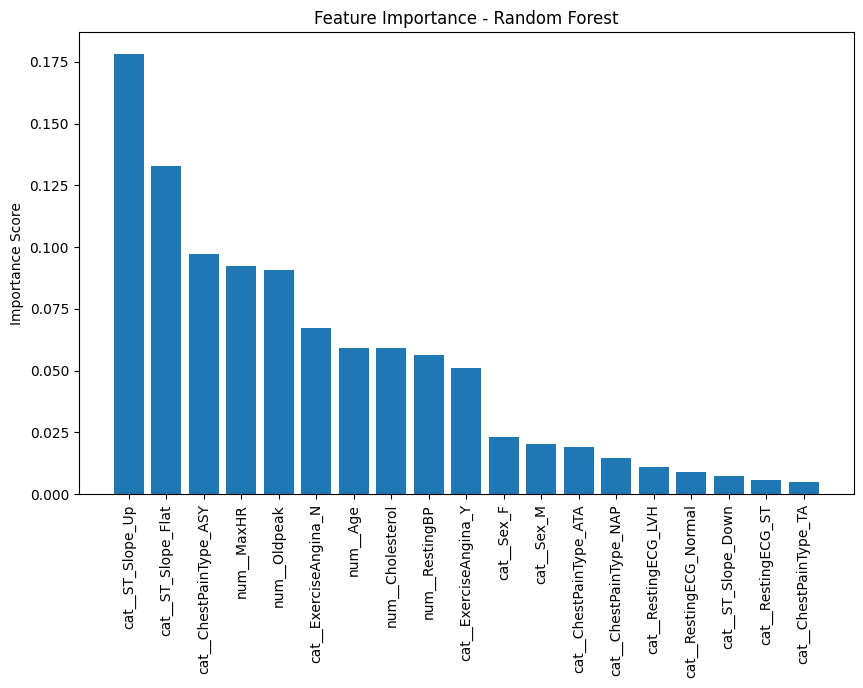

In [202]:
# Get feature names from the preprocessor
preprocessor = rf_best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Access the classifier within the pipeline
rf_classifier = rf_best_model.named_steps['classifier']

# Get feature importances
rf_importances = rf_classifier.feature_importances_

# Ensure the lengths match
assert len(feature_names) == len(rf_importances), "Mismatch between feature names and importances!"

# Create a DataFrame
import pandas as pd
import matplotlib.pyplot as plt

rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.title('Feature Importance - Random Forest')
plt.xticks(rotation=90)
plt.ylabel('Importance Score')
plt.show()


The higher the importance score, the more significant the feature is in making predictions. For example, "cat_ST_Slope_Up" is the most important feature, while "cat_ChestPainType_TA" is the least important among the listed features.


This analysis shows that ECG features (like ST_Slope and Oldpeak) and exercise metrics (like MaxHR and ExerciseAngina) are very important for predicting heart failure. Traditional factors like age and cholesterol still matter, but they're not as crucial in this dataset because ECG and stress test results give more immediate diagnostic value.

Hence, doctors should focus on ECG evaluations and stress tests when checking for heart failure risk, but they shouldn't ignore the traditional factors for a complete risk profile.